In [1]:
# Importing Libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Data Collection and Concatenation

In [2]:
# Appending all scraped data into one CSV
df1 = pd.read_csv("lagos_propertypro_scrape.csv")
df2 = pd.read_csv("lagos_pg151_300.csv")
df3 = pd.read_csv("lagos_pg302_450.csv")
df4 = pd.read_csv("lagos_pg451_500.csv")

# Concatenation i.e appending all data frames to become one dataframe
combined = pd.concat([df1, df2, df3, df4 ], ignore_index=True)

# convert to a csv file
combined.to_csv("Scrapped_propertypro_data.csv", index=False)


# Preview
#print(combined.head(20))

## Data Cleaning, Data Enrichment and Processing

In [3]:

# Load the data
df = pd.read_csv(r"C:\Users\user\OneDrive\Documents\Lagos Housing Data\Scrapped_propertypro_data.csv")

# Step 1: Clean price, bedrooms, bathrooms columns
df['price_naira'] = pd.to_numeric(df['price_naira'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

# Step 2: Create "city" column from second-to-last word in "location"
# Extract second-to-last word from location as city
df['city'] = df['location'].apply(lambda x: str(x).split()[-2].lower() if isinstance(x, str) and len(x.split()) > 1 else None)


# Step 3: Filter out properties not located in Lagos
non_lagos_cities = ["camp", "guzape", "gwarinpa", "abuja", "jahi", "oyo", "ibadan"]
df = df[~df['location'].str.lower().str.contains('|'.join(non_lagos_cities), na=False)]


# Step 4: Remove non-residential properties
keywords = ['land', 'spacious', 'shop space', 'warehouse', 'office space', 'musical', 'seminar', 'commercial property','commercial space', 'shop',
            'commercial use', 'commercial building', 'restaurant space', 'space with elevator', 'office', 'space', 'commercial', 'hotel']
df = df[~df['description'].str.lower().str.contains('|'.join(keywords), na=False)]

# Step 5: Filter price range
df = df[(df['price_naira'] >= 20000) & (df['price_naira'] <= 50000000)]

df['city'] = df['city'].replace({
    'island': 'victoria island',
    'ipaja': 'iyana ipaja',
    'odofin': 'amuwo odofin'
})

df['city'] = df['city'].str.title()

df['city'] = df['city'].str.strip()  # Remove extra spaces
df['city'] = df['city'].replace('Estate', 'Ojodu')


# Step 6: Create house_type column
def classify_house(desc):
    desc = str(desc).lower()
    if "apartment" in desc or "flat" in desc:
        return "Flat & Apartment"
    elif "duplex" in desc:
        return "Duplex"
    elif "maisonette" in desc:
        return "Maisonette"
    elif "mansion" in desc:
        return "Mansion"
    elif "self contain" in desc or "self-contained" in desc:
        return "Self-Contain"
    elif "bungalow" in desc:
        return "Bungalow"
    elif "penthouse" in desc:
        return "Penthouse"
    else:
        return None

# Apply classification
df['house_type'] = df['description'].apply(classify_house)

# Normalize all house_type values to lowercase
df['house_type'] = df['house_type'].str.lower().str.strip()

# Step 7: Create new/old indicator
df['building_age'] = np.where(
    df['description'].str.contains("newly built|brand new|just built", case=False, na=False),
    "New",
    "Old"
)

# Drop rows with missing price
df = df.dropna(subset=['price_naira'])

# Fill missing bedrooms and bathrooms with median by house type
df['bedrooms'] = df['bedrooms'].fillna(df.groupby('house_type')['bedrooms'].transform('median'))
df['bathrooms'] = df['bathrooms'].fillna(df.groupby('house_type')['bathrooms'].transform('median'))

# Step 1: Clean column names
df.columns = df.columns.str.strip().str.lower()


# Optional: Save cleaned data
df.to_csv(r"C:\Users\user\OneDrive\Documents\Lagos Housing Data\Cleaned_propertypro_data.csv", index=False)

# Preview
#print(df.head(20))


## Concatenating data from 2023 vs 2025

In [4]:
# combine the data from 2023 and 2025 together
# note: they must have same headings, in the same order
df_2023 = pd.read_csv("propertypro_lagos(2023).csv")
df_2025 = pd.read_csv("Cleaned_propertypro_data.csv")

# Add a year Column
df_2023['year'] = 2023
df_2025['year'] = 2025

# Concatenation (appending)
combined_df = pd.concat([df_2023, df_2025], ignore_index=True)

# Clean description column
df['description'] = df['description'].astype(str).str.lower()

# Combining as a CSV
combined_df.to_csv("Combined_Dataset.csv", index=False)

# Preview
#print(df.head(20))


# Exploratory data analysis

In [5]:
# Loading the appended dataset
df = pd.read_csv(
    r"C:\Users\user\OneDrive\Documents\Lagos Housing Data\Combined_DataSet.csv", low_memory=False
)
#df.describe()

## Checking the Median rent for 2023 vs 2025

In [6]:
# Median rent for 2023 vs 2025 
median_2023_by_type = df[df['year'] == 2023].groupby('house_type')['price_naira'].median().sort_values(ascending=False)
#print("Median Rent by House Type (2023):")
print(median_2023_by_type)

median_2025_by_type = df[df['year'] == 2025].groupby('house_type')['price_naira'].median().sort_values(ascending=False)
#print("Median Rent by House Type (2025):")
print(median_2025_by_type)


house_type
mansion             15000000.0
maisonette          12000000.0
penthouse            7250000.0
duplex               4500000.0
bungalow             1200000.0
flat & apartment     1000000.0
self-contain          350000.0
Name: price_naira, dtype: float64
house_type
penthouse           22000000.0
maisonette          20000000.0
mansion             14750000.0
duplex              12000000.0
flat & apartment     5000000.0
bungalow             4000000.0
self-contain         1000000.0
Name: price_naira, dtype: float64


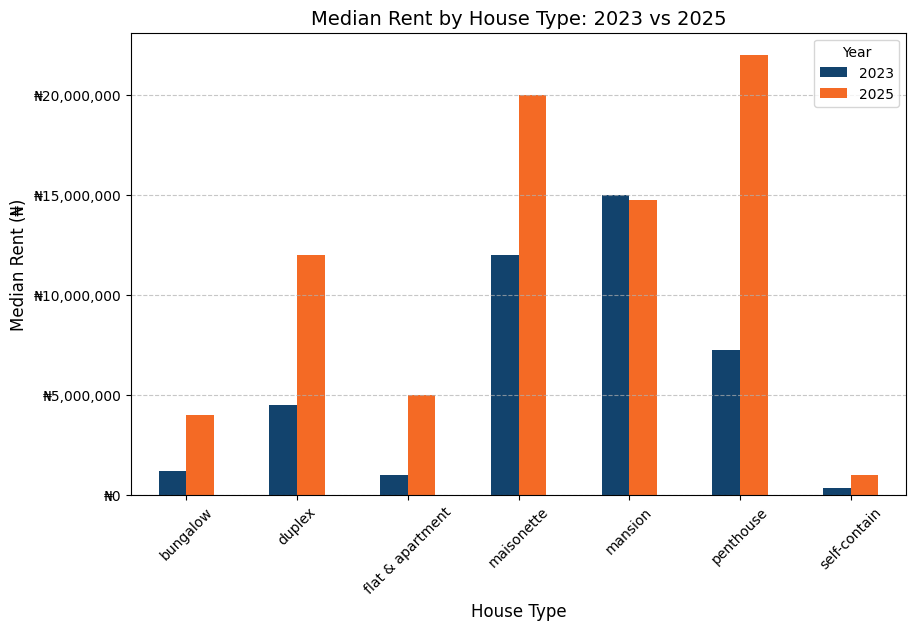

In [7]:
# Combine into DataFrame
median_rent = pd.DataFrame({
    "2023": median_2023_by_type,
    "2025": median_2025_by_type
})

colors = ["#12436D", "#F46A25"]  

ax = median_rent.plot(kind="bar", figsize=(10,6), color=colors)
plt.title("Median Rent by House Type: 2023 vs 2025", fontsize=14)
plt.xlabel("House Type", fontsize=12)
plt.ylabel("Median Rent (₦)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Format y-axis as currency
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"₦{x:,.0f}"))

#Save as PNG
plt.savefig("median_rent_comparison.png", dpi=300, bbox_inches="tight")

#Show the plot
plt.show()

## Descriptive Analysis

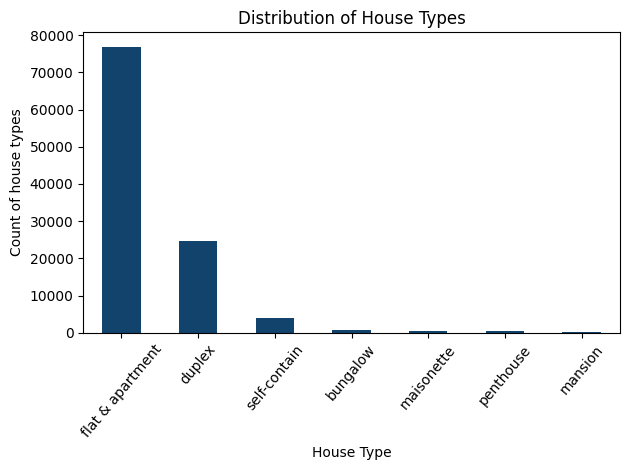

In [8]:
# I want to see the most Common/ most requested type of rental property

colors = ["#12436D"]
df['house_type'].value_counts().plot(kind='bar', title='Distribution of House Types', color=colors)
plt.ylabel("Count of house types")
plt.xlabel("House Type")
plt.xticks(rotation=50)
plt.tight_layout()

#print("\nHouse Type Counts:\n", df['house_type'].value_counts())
plt.savefig("distribution_of_house types.png", dpi=300,)
plt.show()

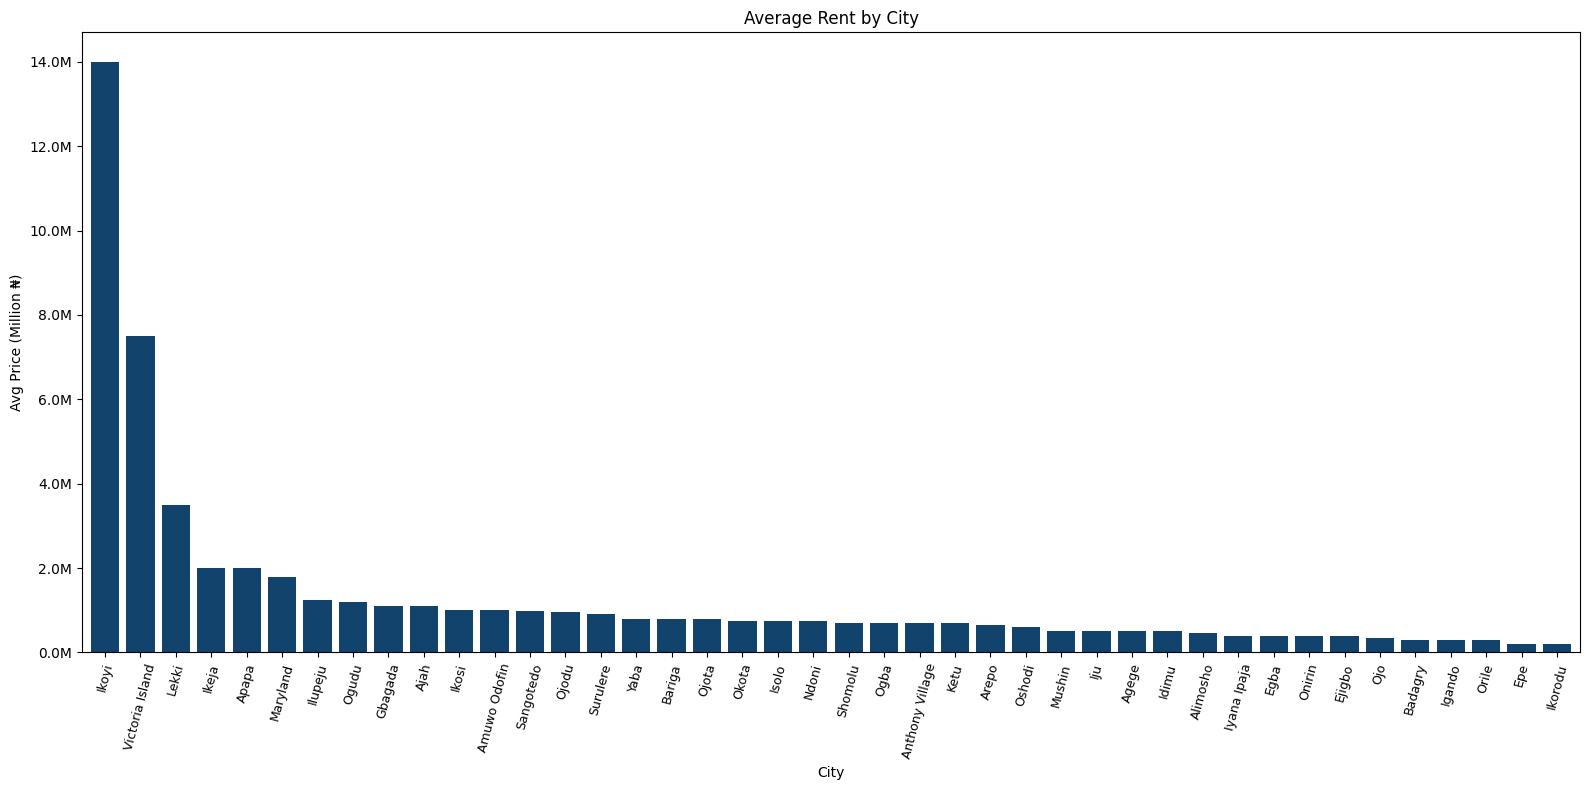

In [9]:
# This is the amount of money an average person pays yearly for rent in these locations

# View city names with their counts
top_cities = df['city'].value_counts().index
avg_price = df[df['city'].isin(top_cities)].groupby('city')['price_naira'].median().sort_values(ascending=False)

plt.figure(figsize=(16, 8))  # Increase width to fit 46 cities

colors=["#12436D"]

ax = avg_price.plot(kind='bar', title='Average Rent by City', width=0.8, color= colors)

# Format y-axis as millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.xlabel("City")
plt.ylabel("Avg Price (Million ₦)")
plt.xticks(rotation=75, fontsize=9)  # Smaller font and angle for readability
plt.tight_layout()

#plt.savefig("Average Rent by City.png", dpi=300,)
plt.show()


In [10]:
print(df.groupby('city')['price_naira'].median().sort_values(ascending=False))


city
Ikoyi              14000000.0
Victoria Island     7500000.0
Lekki               3500000.0
Ikeja               2000000.0
Apapa               2000000.0
Maryland            1800000.0
Ilupeju             1250000.0
Ogudu               1200000.0
Gbagada             1100000.0
Ajah                1100000.0
Ikosi               1000000.0
Amuwo Odofin        1000000.0
Sangotedo            975000.0
Ojodu                950000.0
Surulere             900000.0
Yaba                 800000.0
Bariga               800000.0
Ojota                800000.0
Okota                750000.0
Isolo                750000.0
Ndoni                750000.0
Shomolu              700000.0
Ogba                 700000.0
Anthony Village      700000.0
Ketu                 700000.0
Arepo                650000.0
Oshodi               600000.0
Mushin               500000.0
Iju                  500000.0
Agege                500000.0
Idimu                500000.0
Alimosho             450000.0
Iyana Ipaja          400000.0
Egba 

In [11]:
# If mean > median, it suggest Positve skewness 
median_price = df['price_naira'].median()
mean_price = df['price_naira'].mean()

print(f"Median Rent Price: ₦{median_price:,.0f}")
print(f"Mean Rent Price: ₦{mean_price:,.0f}")

#The mean rent price (₦X) is higher than the median (₦Y), indicating that the distribution is positively skewed. 
# This suggests that while most rent prices cluster around the lower end, a small number of high-rent properties raise the overall average. 
# The histogram further confirms this skew, showing a long tail on the right.


Median Rent Price: ₦1,600,000
Mean Rent Price: ₦16,261,865


In [12]:

# 1. Load your dataset
df = pd.read_csv("Combined_DataSet.csv")

# Ensure proper data types
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['price_naira'] = pd.to_numeric(df['price_naira'], errors='coerce')

# Filter necessary columns and drop any rows missing key info
df = df[['city', 'house_type', 'year', 'price_naira']].dropna()

# Create pivot table: average price by city & house type, for each year
pivot = df.pivot_table(
    index=['city', 'house_type'],
    columns='year',
    values='price_naira',
    aggfunc='median'
)

# Rename columns (only if both years exist)
if 2023 in pivot.columns and 2025 in pivot.columns:
    pivot = pivot.rename(columns={2023: 'Price_2023', 2025: 'Price_2025'})

    # Drop rows where either price is missing
    pivot = pivot.dropna(subset=['Price_2023', 'Price_2025'])

    # Calculate difference and percent change
    pivot['Difference'] = pivot['Price_2025'] - pivot['Price_2023']
    pivot['% Change'] = ((pivot['Difference'] / pivot['Price_2023']))

    # Reset index for viewing
    result = pivot.reset_index()
    print(result)
else:
    print("Data for both 2023 and 2025 not available in all entries.")

#result.to_csv("Rent_Comparison_By_City_HouseType.csv", index=False)




year             city        house_type  Price_2023  Price_2025  Difference  \
0               Agege            duplex   1500000.0    550000.0   -950000.0   
1               Agege  flat & apartment    500000.0   2500000.0   2000000.0   
2                Ajah          bungalow   1500000.0   3500000.0   2000000.0   
3                Ajah            duplex   2500000.0   6500000.0   4000000.0   
4                Ajah  flat & apartment    850000.0   2300000.0   1450000.0   
..                ...               ...         ...         ...         ...   
99    Victoria Island         penthouse   7500000.0  25500000.0  18000000.0   
100   Victoria Island      self-contain   1000000.0   4500000.0   3500000.0   
101              Yaba            duplex   3000000.0   7500000.0   4500000.0   
102              Yaba  flat & apartment    850000.0   3000000.0   2150000.0   
103              Yaba      self-contain    350000.0   1000000.0    650000.0   

year  % Change  
0    -0.633333  
1     4.000000  


In [13]:
# Filter the data for Surulere and 2-Bedroom
filtered = df[
    (df['city'].str.lower() == 'surulere') &
    (df['house_type'].str.lower().str.contains('flat & apartment'))
]

# Group by year and get the median price
median_rent = filtered.groupby('year')['price_naira'].median()

# Extract values
price_2023 = median_rent.get(2023, None)
price_2025 = median_rent.get(2025, None)

# Calculate percentage change
if price_2023 and price_2025:
    percent_change = ((price_2025 - price_2023) / price_2023) * 100
    print(f"While the median rent for a 2-bedroom in Surulere rose from ₦{int(price_2023):,} to ₦{int(price_2025):,} (a {percent_change:.1f}% increase).")
else:
    print("Missing 2023 or 2025 data for Surulere 2-Bedroom.")


While the median rent for a 2-bedroom in Surulere rose from ₦800,000 to ₦2,650,000 (a 231.2% increase).


In [16]:
df = pd.read_csv(
    r"C:\Users\user\OneDrive\Documents\Lagos Housing Data\Combined_DataSet.csv", low_memory=False
)

# Group by year and building condition, then calculate average price
avg_price = df.groupby(["year", "building_age"])["price_naira"].median().reset_index()

# Pivot to compare 2023 vs 2025 side by side
avg_price_pivot = avg_price.pivot(index="building_age", columns="year", values="price_naira")

# Rename columns for clarity
avg_price_pivot = avg_price_pivot.rename(columns={2023: "2023 Avg Price", 2025: "2025 Avg Price"})

# Calculate % change
avg_price_pivot["% Change"] = ((avg_price_pivot["2025 Avg Price"] - avg_price_pivot["2023 Avg Price"]) / avg_price_pivot["2023 Avg Price"]) * 100

# Format nicely
avg_price_pivot = avg_price_pivot.round(2)

print(avg_price_pivot)

year          2023 Avg Price  2025 Avg Price  % Change
building_age                                          
New                1200000.0       4000000.0    233.33
Old                1500000.0       8000000.0    433.33


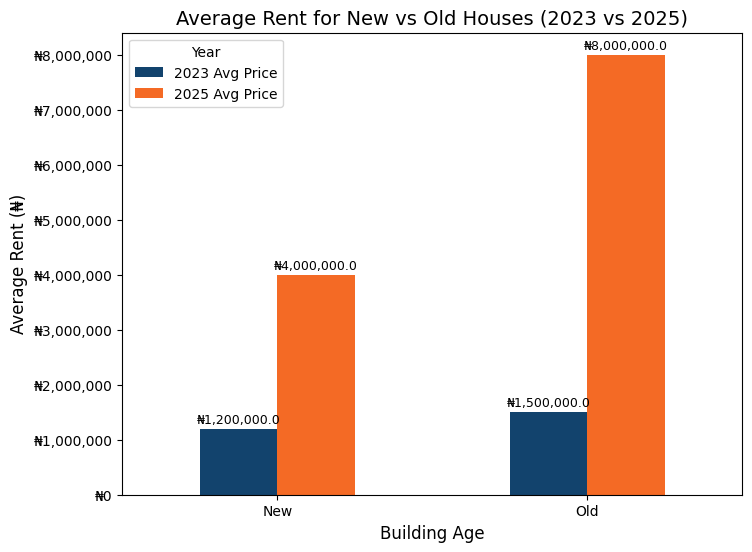

In [ ]:
plot_data = avg_price_pivot[["2023 Avg Price", "2025 Avg Price"]]

colors = ["#12436D","#F46A25"]

ax = plot_data.plot(
    kind="bar",
    figsize=(8,6),
    color=colors
)

# Titles and labels
plt.title("Average Rent for New vs Old Houses (2023 vs 2025)", fontsize=14)
plt.xlabel("Building Age", fontsize=12)
plt.ylabel("Average Rent (₦)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Year")

# Format y-axis as Naira with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"₦{x:,.0f}"))

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="₦{:,}", label_type="edge", fontsize=9, padding=2)

# Save as PNG
plt.savefig("avg_rent_new_vs_old.png", dpi=300, bbox_inches="tight")

plt.show()